In [1]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from math import ceil
import multiprocessing
from collections import Counter
from torchvision import transforms
from PIL import Image
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib
import matplotlib.patches as mpatches
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import StratifiedKFold
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from memory_profiler import memory_usage
import time
import torchvision.models as models
from collections import OrderedDict

/mmfs1/cm/shared/apps_local/python/3.11/envs/torch2.2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomDataset(Dataset):
    def __init__(self, dataset_path, gt_masks_path=None, num_sequences=None, is_training=True, transform=None, target_size=(224, 144), segment_length=17):
        self.dataset_path = dataset_path
        self.gt_masks_path = gt_masks_path
        self.num_sequences = num_sequences
        self.is_training = is_training
        self.transform = transform
        self.target_size = target_size
        self.segment_length = segment_length
        self.max_track_id = 19  
        self.track_id_mapping = self.create_track_id_mapping()
        self.sequence_folders = sorted(os.listdir(self.dataset_path))
        # Filter out the ground truth folders and unwanted folders
        self.sequence_folders = sorted([
            folder for folder in os.listdir(self.dataset_path) 
            if os.path.isdir(os.path.join(self.dataset_path, folder)) 
            and '_gt' not in folder 
            and '.ipynb_checkpoints' not in folder
        ])
    def create_track_id_mapping(self):
        track_ids = np.arange(1, self.max_track_id + 1)
        normalized_track_ids = track_ids / self.max_track_id
        track_id_mapping = dict(zip(track_ids, normalized_track_ids))
        return track_id_mapping

    def create_segments(self, frames, labels, segment_length=11):
        num_frames = len(frames)
        half_segment = segment_length // 2

        segments = []
        segment_labels = []

        for i in range(num_frames):
            segment = []

            for j in range(i - half_segment, i):
                if j < 0:
                    segment.append(np.zeros_like(frames[0])) 
                else:
                    segment.append(frames[j])

            segment.append(frames[i])

            for j in range(i + 1, i + 1 + half_segment):
                if j >= num_frames:
                    segment.append(np.zeros_like(frames[0])) 
                else:
                    segment.append(frames[j])
           
            segments.append(segment)
            segment_labels.append(labels[i])     
        
        return segments, segment_labels
    
    def process_sequence(self, sequence_folder):        
        sequence_path = os.path.join(self.dataset_path, sequence_folder)
        # Check if the sequence folder is a directory and doesn't contain '_gt' or '.ipynb_checkpoints'
        if not os.path.isdir(sequence_path):
            return [], [], []
    
        
        sequence_frames = []
        sequence_tracking_data = []
        sequence_labels = []
        
        label_folder = os.path.join(sequence_path, 'labels')
        if not os.path.exists(label_folder):
            return [], [], []

        tracking_data = {}

        for label_file in sorted(os.listdir(label_folder)):
            if not label_file.endswith('.txt'):
                continue

            frame_id = int(os.path.splitext(label_file)[0])
            tracking_data[frame_id] = []

            with open(os.path.join(label_folder, label_file), 'r') as f:
                lines = f.readlines()
                for line in lines:
                    line_split = line.strip().split(' ')
                    if len(line_split) < 6:
                        continue

                    x = float(line_split[1])
                    y = float(line_split[2])
                    width = float(line_split[3])
                    height = float(line_split[4])
                    track_id = int(line_split[5])
                    tracking_data[frame_id].append({'track_id': track_id, 'x': x, 'y': y, 'width': width, 'height': height})

        for frame_index, track_data_list in tracking_data.items():
            img_filename = "{:03d}.tif".format(frame_index)
            img_path = os.path.join(sequence_path, img_filename)
            frame = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            #frame = cv2.resize(frame, self.target_size, interpolation=cv2.INTER_AREA)

            tracking_data_channel = np.zeros_like(frame, dtype=np.float32)                

            for track_data in track_data_list:
                x, y = track_data['x'], track_data['y']
                width, height = track_data['width'], track_data['height']
                track_id = track_data['track_id']
                normalized_track_id = self.track_id_mapping.get(track_id, 0.0)

                x_pixel = int(x * frame.shape[1])
                y_pixel = int(y * frame.shape[0])
                width_pixel = int(width * frame.shape[1])
                height_pixel = int(height * frame.shape[0])

                for y_idx in range(y_pixel, y_pixel + height_pixel):
                    for x_idx in range(x_pixel, x_pixel + width_pixel):
                        if 0 <= x_idx < frame.shape[1] and 0 <= y_idx < frame.shape[0]:
                            tracking_data_channel[y_idx, x_idx] = normalized_track_id                                

            
            frame_pil = Image.fromarray(frame) 
            tracking_data_channel_pil = Image.fromarray(tracking_data_channel)  
            
            # Apply transformations
            if self.transform:
                seed = np.random.randint(0, 2**32)  # Generate random seed
                random.seed(seed)
                torch.manual_seed(seed)

                frame_pil = self.transform(frame_pil)
                random.seed(seed)  # Reset the seed
                torch.manual_seed(seed)

                tracking_data_channel_pil = self.transform(tracking_data_channel_pil)
            # Convert the transformed PIL images back to numpy arrays
            frame = np.array(frame_pil)
            tracking_data_channel = np.array(tracking_data_channel_pil)  
            frame = np.transpose(frame, (1, 2, 0)) 
            tracking_data_channel = np.transpose(tracking_data_channel, (1, 2, 0)) 
            #print(frame.shape)
            frame = np.concatenate((frame, tracking_data_channel), axis=-1)# Combine along the channel dimension 
            sequence_frames.append(frame)           

            if not self.is_training and self.gt_masks_path:
                gt_mask_path = os.path.join(self.gt_masks_path, sequence_folder + "_gt", img_filename.replace('.tif', '.bmp'))
                if os.path.exists(gt_mask_path):
                    gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
                    if gt_mask is not None:
                        label = int(np.max(gt_mask) > 0)
                        sequence_labels.append(label)
                    else:
                        label = 0
                        sequence_labels.append(label)
                else:
                    label = 0
                    sequence_labels.append(label)
            elif self.is_training:
                label = 0
                sequence_labels.append(label)

        segment_frames, segment_labels = self.create_segments(sequence_frames, sequence_labels, segment_length=self.segment_length)
        segment_frames = np.stack(segment_frames)        
        segment_labels = np.stack(segment_labels)
        
        return segment_frames, segment_labels

    def __len__(self):
        return len(self.sequence_folders)

    def __getitem__(self, idx):
        sequence_folder = self.sequence_folders[idx]
        segment_frames, segment_labels = self.process_sequence(sequence_folder)
        return segment_frames, segment_labels


In [3]:
# Define the dataset path and ground truth masks path
train_dataset_path = '/mmfs1/scratch/jacks.local/ojanigala/Anomaly_Detection/UCSDped1/Train'  # Path to the train dataset
test_dataset_path = '/mmfs1/scratch/jacks.local/ojanigala/Anomaly_Detection/UCSDped1/Test'    # Path to the test dataset
test_gt_masks_path = '/mmfs1/scratch/jacks.local/ojanigala/Anomaly_Detection/UCSDped1/Test'   # Path to the test ground truth masks

# Define transformations for data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])



try:
    # Initialize the dataset for training and testing
    train_dataset = CustomDataset(train_dataset_path, is_training=True, transform=transform)
    test_dataset = CustomDataset(test_dataset_path, gt_masks_path=test_gt_masks_path, is_training=False, transform=transform)
    
except Exception as e:
    print("Error loading datasets:", e)
    exit(1)


# Calculate the split index
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_indices = list(range(train_size))
val_indices = list(range(train_size, len(train_dataset)))

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)


In [4]:
# Set a unique seed value for this notebook
SEED = 42  

# Set seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Ensure deterministic behavior for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


batch_size = 1
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
full_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

def print_batch_samples(loader, num_batches=2):
    for i, (frames, labels) in enumerate(loader):
        if i >= num_batches:
            break
        print(f"Batch {i + 1}:")
        print("Frames shape:", frames.shape)
        print("Labels:", labels.shape)
        

print("Training DataLoader:")
print_batch_samples(train_loader)

print("Validation DataLoader:")
print_batch_samples(val_loader)



train_subset_length = len(train_subset)
val_subset_length = len(val_subset)
test_length = len(test_dataset)

print(f"Number of samples in the train subset: {train_subset_length}")
print(f"Number of samples in the val subset: {val_subset_length}")
print(f"Number of samples in the test: {test_length}")

for i, batch in enumerate(train_loader):
    frames, labels = batch
    print("Batch Frames shape:", frames.shape)    
    print("Batch Labels shape:", labels.shape)
    if i == 0: 
        break


Training DataLoader:
Batch 1:
Frames shape: torch.Size([1, 200, 17, 158, 238, 2])
Labels: torch.Size([1, 200])
Batch 2:
Frames shape: torch.Size([1, 200, 17, 158, 238, 2])
Labels: torch.Size([1, 200])
Validation DataLoader:
Batch 1:
Frames shape: torch.Size([1, 200, 17, 158, 238, 2])
Labels: torch.Size([1, 200])
Batch 2:
Frames shape: torch.Size([1, 200, 17, 158, 238, 2])
Labels: torch.Size([1, 200])
Number of samples in the train subset: 27
Number of samples in the val subset: 7
Number of samples in the test: 36
Batch Frames shape: torch.Size([1, 200, 17, 158, 238, 2])
Batch Labels shape: torch.Size([1, 200])


In [5]:
def print_memory_usage():
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

        
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels * self.expansion),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        # print("BasicBlock Module...")
        # print_memory_usage()
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.conv3 = nn.Conv3d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = None
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels * self.expansion),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)  
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)  
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        # print("Bottleneck Module...")
        # print_memory_usage()
        return out

        
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.max_pool = nn.AdaptiveMaxPool3d(1)

        self.fc = nn.Sequential(
            nn.Conv3d(in_channels, in_channels // reduction_ratio, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels // reduction_ratio, in_channels, kernel_size=1, bias=False)
        )

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return torch.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv3d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.bn = nn.BatchNorm3d(1)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        out = self.bn(out)
        return torch.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        out = x * self.channel_attention(x)
        out = out * self.spatial_attention(out)
        return out



class ResNet3D(nn.Module):
    def __init__(self, block, layers, num_classes=1, in_channels=1):
        super(ResNet3D, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout3d(p=0.5)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

class ResNet3D_CBAM(ResNet3D):
    def __init__(self, block, layers, num_classes=1, in_channels=2):
        super(ResNet3D_CBAM, self).__init__(block, layers, num_classes, in_channels)
        
        # CBAM modules for the ResNet3D layers
        self.cbam1 = CBAM(64 * block.expansion)
        self.cbam2 = CBAM(128 * block.expansion)
        self.cbam3 = CBAM(256 * block.expansion)
        self.cbam4 = CBAM(512 * block.expansion)

        # Cross-Attention for late fusion
        self.embed_dim = 512  # Match this to the ResNet output dimension
        self.num_heads = 4
        
        # Final classification layer after fusion
        self.fc_final = nn.Linear(512, num_classes)

    def forward(self, x_frames):
        # Process frames modality
        x_frames = self.conv1(x_frames)
        x_frames = self.bn1(x_frames)
        x_frames = self.relu(x_frames)
        x_frames = self.maxpool(x_frames)

        x_frames = self.layer1(x_frames)
        x_frames = self.cbam1(x_frames)
        x_frames = self.layer2(x_frames)
        x_frames = self.cbam2(x_frames)
        x_frames = self.layer3(x_frames)
        x_frames = self.cbam3(x_frames)
        x_frames = self.layer4(x_frames)
        x_frames = self.cbam4(x_frames)
        #print("x_frames:",x_frames.shape)
        
        x_frames = self.avgpool(x_frames)
        x_frames = x_frames.view(x_frames.size(0), -1)

        # Final classification layer
        x_out = self.fc_final(x_frames)

        return x_out




def resnet10_cbam(in_channels=1):
    return ResNet3D_CBAM(BasicBlock, [1, 1, 1, 1], in_channels=in_channels)

def resnet18_cbam(in_channels=1):
    return ResNet3D_CBAM(BasicBlock, [2, 2, 2, 2], in_channels=in_channels)

def resnet34_cbam(in_channels=1):
    return ResNet3D_CBAM(BasicBlock, [3, 4, 6, 3], in_channels=in_channels)

def resnet50_cbam(in_channels=1):
    return ResNet3D_CBAM(Bottleneck, [3, 4, 6, 3], in_channels=in_channels)



Using 2 GPUs!
Epoch 1/100, Train Loss: 0.058495, Train Accuracy: 96.30%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 1/100, Val Loss: 0.000809, Val Accuracy: 100.00%, Val Precision: 1.0000, Val Recall: 1.0000, Val F1: 1.0000
Epoch 2/100, Train Loss: 0.000580, Train Accuracy: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 2/100, Val Loss: 0.000422, Val Accuracy: 100.00%, Val Precision: 1.0000, Val Recall: 1.0000, Val F1: 1.0000
Epoch 3/100, Train Loss: 0.000350, Train Accuracy: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 3/100, Val Loss: 0.000297, Val Accuracy: 100.00%, Val Precision: 1.0000, Val Recall: 1.0000, Val F1: 1.0000
Epoch 4/100, Train Loss: 0.000242, Train Accuracy: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 4/100, Val Loss: 0.000199, Val Accuracy: 100.00%, Val Precision: 1.0000, Val Recall: 1.0000, Val F1: 1.0000
Epoch 5/100, Train Loss: 0.000152, 

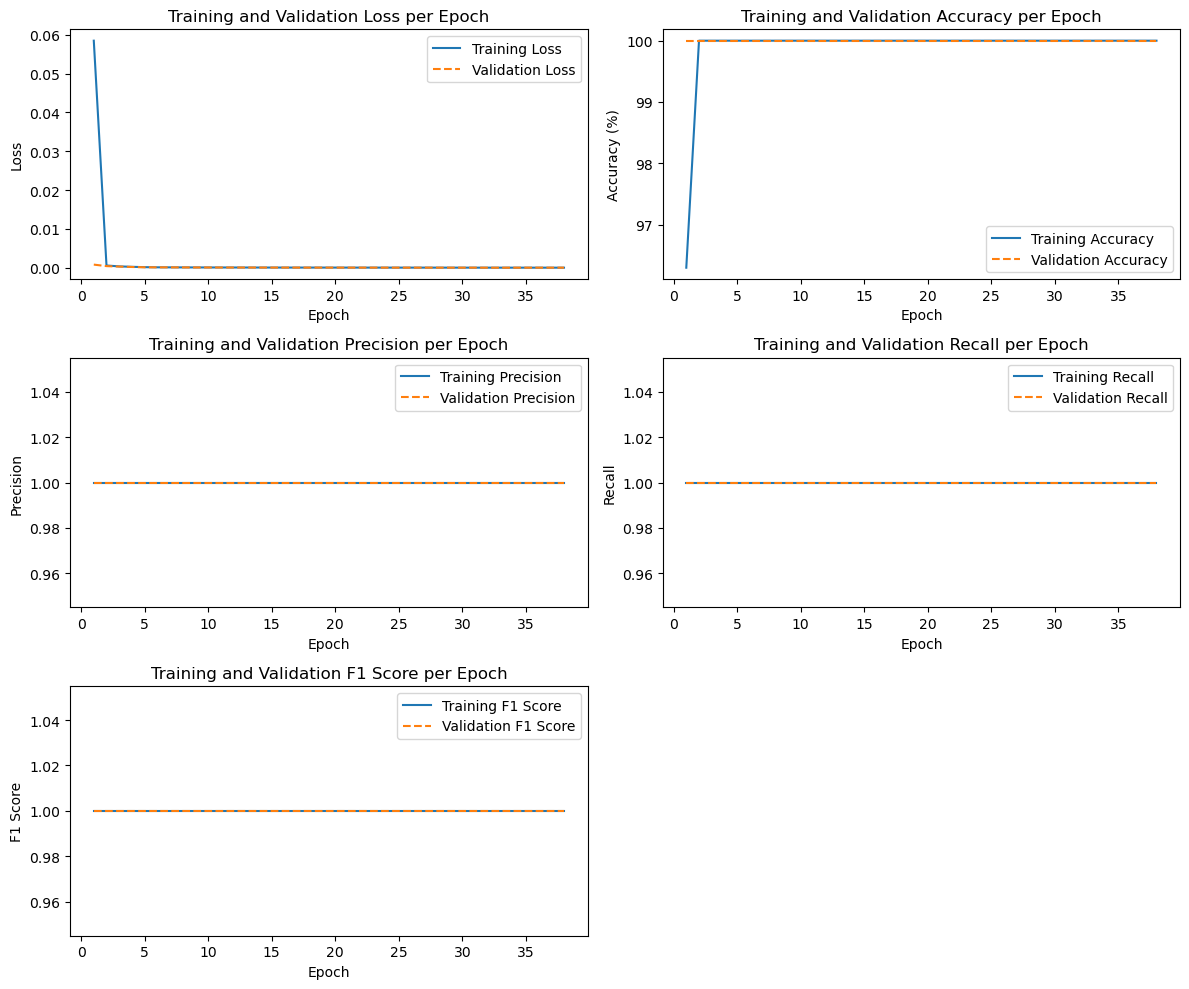

In [6]:
# Define model, criterion, optimizer, and scheduler
model = resnet34_cbam(in_channels=2)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use DataParallel to utilize multiple GPUs
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
model.to(device)

# Training model with Early Stopping 
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_aucs = []
    val_aucs = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_f1s = []
    val_f1s = []
    best_val_loss = float('inf')
    best_model_state = None
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        all_train_labels = []
        all_train_preds = []
        
        for frames, labels in train_loader:
            frames, labels = frames.to(device), labels.to(device)
            frames, labels = frames.float(), labels.float()
            frames = frames.view(-1, frames.shape[2], frames.shape[3], frames.shape[4], frames.shape[5])
            
            frames = frames.permute(0, 4, 1, 2, 3)    
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = model(frames)
            loss = criterion(outputs.view(-1), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate accuracy
            predicted_train = torch.sigmoid(outputs.view(-1)) > 0.5
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
            
            # Collect labels and predictions for AUC and other metrics
            all_train_labels.append(labels.cpu().numpy())
            all_train_preds.append(outputs.view(-1).cpu().detach().numpy())

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        #train_auc = roc_auc_score(np.concatenate(all_train_labels), np.concatenate(all_train_preds))
        train_precision = precision_score(np.concatenate(all_train_labels), np.concatenate(all_train_preds) > 0.5,average='weighted',zero_division=1)
        train_recall = recall_score(np.concatenate(all_train_labels), np.concatenate(all_train_preds) > 0.5,average='weighted',zero_division=1)
        train_f1 = f1_score(np.concatenate(all_train_labels), np.concatenate(all_train_preds) > 0.5,average='weighted',zero_division=1)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        #train_aucs.append(train_auc)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)
        
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Train Accuracy: {train_accuracy:.2f}%, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_val_labels = []
        all_val_preds = []
        
        with torch.no_grad():
            for frames, labels in val_loader:
                frames, labels = frames.to(device), labels.to(device)
                frames, labels = frames.float(), labels.float()
                frames = frames.view(-1, frames.shape[2], frames.shape[3], frames.shape[4], frames.shape[5])
                frames = frames.permute(0, 4, 1, 2, 3)  
                labels = labels.view(-1)
                outputs = model(frames)
                loss = criterion(outputs.view(-1), labels)
                val_loss += loss.item()

                # Calculate accuracy
                predicted_val = torch.sigmoid(outputs.view(-1)) > 0.5
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()
                
                # Collect labels and predictions for AUC and other metrics
                all_val_labels.append(labels.cpu().numpy())
                all_val_preds.append(outputs.view(-1).cpu().detach().numpy())

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        #val_auc = roc_auc_score(np.concatenate(all_val_labels), np.concatenate(all_val_preds))
        val_precision = precision_score(np.concatenate(all_val_labels),np.concatenate(all_val_preds) > 0.5,average='weighted',zero_division=1)
        val_recall = recall_score(np.concatenate(all_val_labels), np.concatenate(all_val_preds) > 0.5,average='weighted',zero_division=1)
        val_f1 = f1_score(np.concatenate(all_val_labels), np.concatenate(all_val_preds) > 0.5,average='weighted',zero_division=1)
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        #val_aucs.append(val_auc)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        
        print(f'Epoch {epoch + 1}/{num_epochs}, Val Loss: {val_loss:.6f}, Val Accuracy: {val_accuracy:.2f}%, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            no_improve_epochs = 0
            torch.save(best_model_state, 'best_model.pth')
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print("Early stopping due to no improvement in validation loss.")
                break

    # Load the best model state
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses, train_accuracies, val_accuracies, train_precisions, val_precisions, train_recalls, val_recalls, train_f1s, val_f1s

# Timing training / validation
start_time = time.time()
model, train_losses, val_losses, train_accuracies, val_accuracies, train_precisions, val_precisions, train_recalls, val_recalls, train_f1s, val_f1s = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=5)
end_time = time.time()
train_val_duration = (end_time - start_time)/60
print(f"Training / Valdiation Time: {train_val_duration:.2f} minutes")
# Plotting the metrics
plt.figure(figsize=(12, 10))

# Plot training and validation loss
plt.subplot(3, 2, 1)
plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Training Loss', linestyle='-')
plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()

# Plot training and validation accuracy
plt.subplot(3, 2, 2)
plt.plot(np.arange(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', linestyle='-')
plt.plot(np.arange(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()


# Plot training and validation Precision
plt.subplot(3, 2, 3)
plt.plot(np.arange(1, len(train_precisions) + 1), train_precisions, label='Training Precision', linestyle='-')
plt.plot(np.arange(1, len(val_precisions) + 1), val_precisions, label='Validation Precision', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training and Validation Precision per Epoch')
plt.legend()

# Plot training and validation Recall
plt.subplot(3, 2, 4)
plt.plot(np.arange(1, len(train_recalls) + 1), train_recalls, label='Training Recall', linestyle='-')
plt.plot(np.arange(1, len(val_recalls) + 1), val_recalls, label='Validation Recall', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training and Validation Recall per Epoch')
plt.legend()


# Plot training and validation F1 Score
plt.subplot(3, 2, 5)
plt.plot(np.arange(1, len(train_f1s) + 1), train_f1s, label='Training F1 Score', linestyle='-')
plt.plot(np.arange(1, len(val_f1s) + 1), val_f1s, label='Validation F1 Score', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
print(f'Average Train Loss: {np.mean(train_losses)}')
print(f'Average Val Loss: {np.mean(val_losses)}')
print(f'Average Train Accuracy: {np.mean(train_accuracies)}')
print(f'Average Val Accuracy: {np.mean(val_accuracies)}') 
print(f'Average Train Accuracy: {np.mean(train_precisions)}')
print(f'Average Val Accuracy: {np.mean(val_precisions)}') 
print(f'Average Train Accuracy: {np.mean(train_recalls)}')
print(f'Average Val Accuracy: {np.mean(val_recalls)}') 
print(f'Average Train Accuracy: {np.mean(train_f1s)}')
print(f'Average Val Accuracy: {np.mean(val_f1s)}') 
best_model_state = model.state_dict()
torch.save(best_model_state, 'best_model_res18_early.pth')

Average Train Loss: 0.0016149024698405266
Average Val Loss: 8.585398098804766e-05
Average Train Accuracy: 99.90253411306044
Average Val Accuracy: 100.0
Average Train Accuracy: 1.0
Average Val Accuracy: 1.0
Average Train Accuracy: 1.0
Average Val Accuracy: 1.0
Average Train Accuracy: 1.0
Average Val Accuracy: 1.0


Using 2 GPUs!
Epoch 1/33, Train Loss: 0.038472, Train Accuracy: 97.72%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 2/33, Train Loss: 0.000339, Train Accuracy: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 3/33, Train Loss: 0.000166, Train Accuracy: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 4/33, Train Loss: 0.000120, Train Accuracy: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 5/33, Train Loss: 0.000098, Train Accuracy: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 6/33, Train Loss: 0.000085, Train Accuracy: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 7/33, Train Loss: 0.000074, Train Accuracy: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 8/33, Train Loss: 0.000068, Train Accuracy: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epo

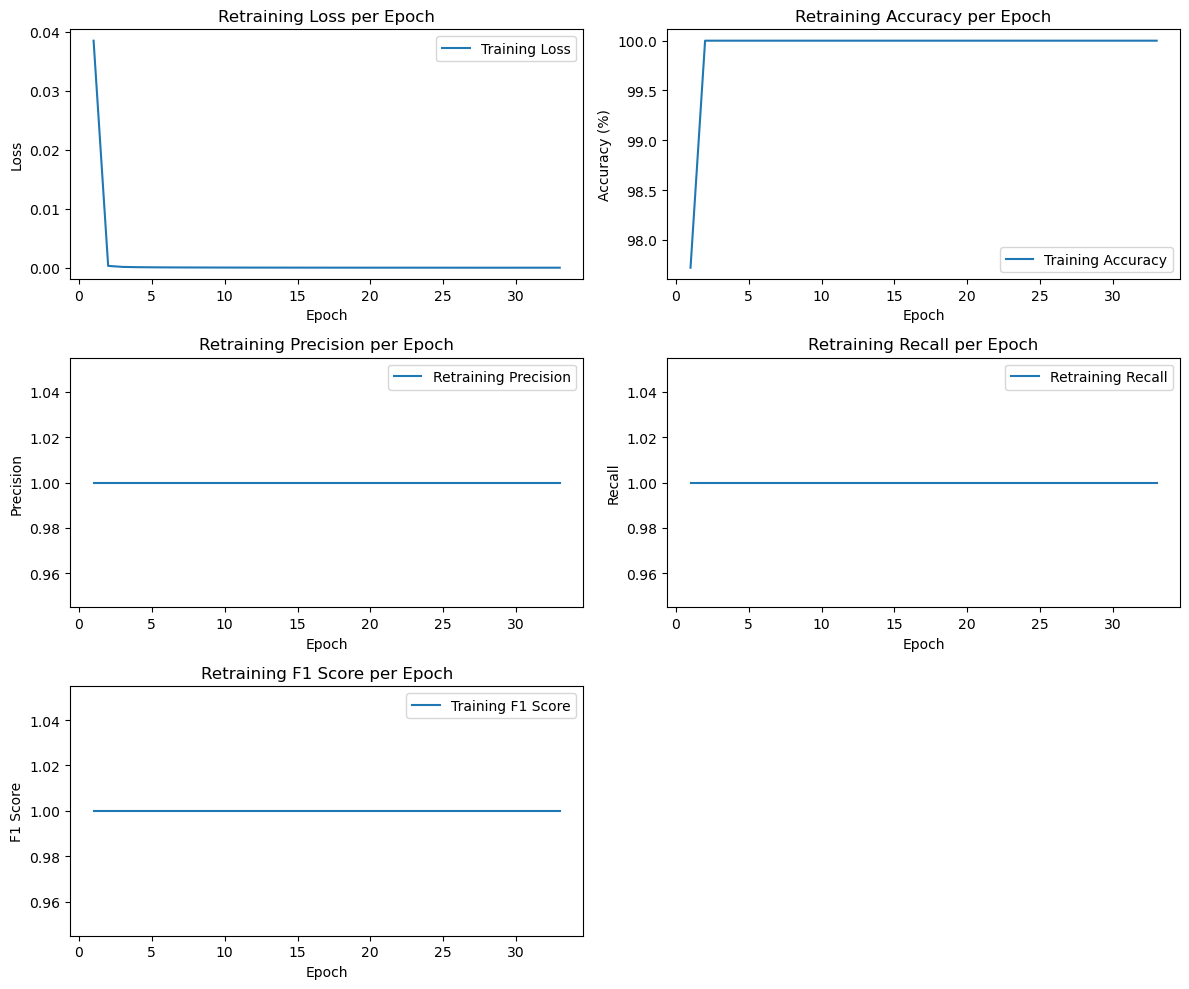

In [8]:
# Define model, criterion, optimizer, and scheduler
model = resnet34_cbam(in_channels=2)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=  0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use DataParallel to utilize multiple GPUs
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
model.to(device)

# ReTraining model with Early Stopping 
def retrain_model(model, full_train_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    retrain_losses = []
    retrain_accuracies = []
    retrain_aucs = []    
    retrain_precisions = []    
    retrain_recalls = []   
    retrain_f1s = []
    
    best_retrain_loss = float('inf')
    best_model_state = None
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        retrain_loss = 0.0
        correct_retrain = 0
        total_retrain = 0
        all_retrain_labels = []
        all_retrain_preds = []
        
        for frames, labels in (full_train_loader):
            frames, labels = frames.to(device), labels.to(device)
            frames, labels = frames.float(), labels.float()
            frames = frames.view(-1, frames.shape[2], frames.shape[3], frames.shape[4], frames.shape[5])
            frames = frames.permute(0, 4, 1, 2, 3)    
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = model(frames)
            loss = criterion(outputs.view(-1), labels)
            loss.backward()
            optimizer.step()
            retrain_loss += loss.item()

            # Calculate accuracy
            predicted_retrain = torch.sigmoid(outputs.view(-1)) > 0.5
            total_retrain += labels.size(0)
            correct_retrain += (predicted_retrain == labels).sum().item()
            
            # Collect labels and predictions for AUC and other metrics
            all_retrain_labels.append(labels.cpu().numpy())
            all_retrain_preds.append(outputs.view(-1).cpu().detach().numpy())

        retrain_loss /= len(full_train_loader)
        retrain_accuracy = 100 * correct_retrain / total_retrain
        #train_auc = roc_auc_score(np.concatenate(all_train_labels), np.concatenate(all_train_preds))
        retrain_precision = precision_score(np.concatenate(all_retrain_labels), np.concatenate(all_retrain_preds) > 0.5,average='weighted',zero_division=1)
        retrain_recall = recall_score(np.concatenate(all_retrain_labels), np.concatenate(all_retrain_preds) > 0.5,average='weighted',zero_division=1)
        retrain_f1 = f1_score(np.concatenate(all_retrain_labels), np.concatenate(all_retrain_preds) > 0.5,average='weighted',zero_division=1)
        #print(retrain_loss)
        retrain_losses.append(retrain_loss)
        retrain_accuracies.append(retrain_accuracy)
        #train_aucs.append(train_auc)
        retrain_precisions.append(retrain_precision)
        retrain_recalls.append(retrain_recall)
        retrain_f1s.append(retrain_f1)
        
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {retrain_loss:.6f}, Train Accuracy: {retrain_accuracy:.2f}%, Train Precision: {retrain_precision:.4f}, Train Recall: {retrain_recall:.4f}, Train F1: {retrain_f1:.4f}')

              
      

    return model, retrain_losses, retrain_accuracies, retrain_precisions, retrain_recalls, retrain_f1s, 

start_time_retrain = time.time()
model, retrain_losses, retrain_accuracies, retrain_precisions, retrain_recalls, retrain_f1s = retrain_model(model, full_train_loader, criterion, optimizer, scheduler, num_epochs= 33, patience=1)
end_time_retrain = time.time()
retrain_duration = end_time_retrain - start_time_retrain
# Plotting the metrics
plt.figure(figsize=(12, 10))

# Plot retraining loss
plt.subplot(3, 2, 1)
plt.plot(np.arange(1, len(retrain_losses) + 1), retrain_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Retraining Loss per Epoch')
plt.legend()

# Plot retraining accuracy
plt.subplot(3, 2, 2)
plt.plot(np.arange(1, len(retrain_accuracies) + 1), retrain_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Retraining Accuracy per Epoch')
plt.legend()


# Plot retraining Precision
plt.subplot(3, 2, 3)
plt.plot(np.arange(1, len(retrain_precisions) + 1), retrain_precisions, label='Retraining Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Retraining Precision per Epoch')
plt.legend()

# Plot retraining Recall
plt.subplot(3, 2, 4)
plt.plot(np.arange(1, len(retrain_recalls) + 1), retrain_recalls, label='Retraining Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Retraining Recall per Epoch')
plt.legend()

# Plot retraining F1 Score
plt.subplot(3, 2, 5)
plt.plot(np.arange(1, len(retrain_f1s) + 1), retrain_f1s, label='Training F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Retraining F1 Score per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
print(f'Average Retrain Loss: {np.mean(retrain_losses)}')
print(f'Average Rerain Accuracy: {np.mean(retrain_accuracies)}')

Average Retrain Loss: 0.0012237528724657353
Average Rerain Accuracy: 99.93092691622104


Batch Loss: 0.0000, Batch Accuracy: 100.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Batch Loss: 0.0000, Batch Accuracy: 100.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Batch Loss: 0.0000, Batch Accuracy: 100.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Batch Loss: 0.0000, Batch Accuracy: 100.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Batch Loss: 0.0000, Batch Accuracy: 100.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Batch Loss: 0.0000, Batch Accuracy: 100.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Batch Loss: 2.5336, Batch Accuracy: 87.8571, Precision: 0.8933, Recall: 0.8786, F1: 0.8218, AUC: 1.0000
Batch Loss: 1.1890, Batch Accuracy: 84.6875, Precision: 0.8703, Recall: 0.8469, F1: 0.7767, AUC: 1.0000
Batch Loss: 0.0330, Batch Accuracy: 86.3889, Precision: 0.8824, Recall: 0.8639, F1: 0.8008, AUC: 1.0000
Batch Loss: 0.0009, Batch Accuracy: 87.7500, Precision: 0.

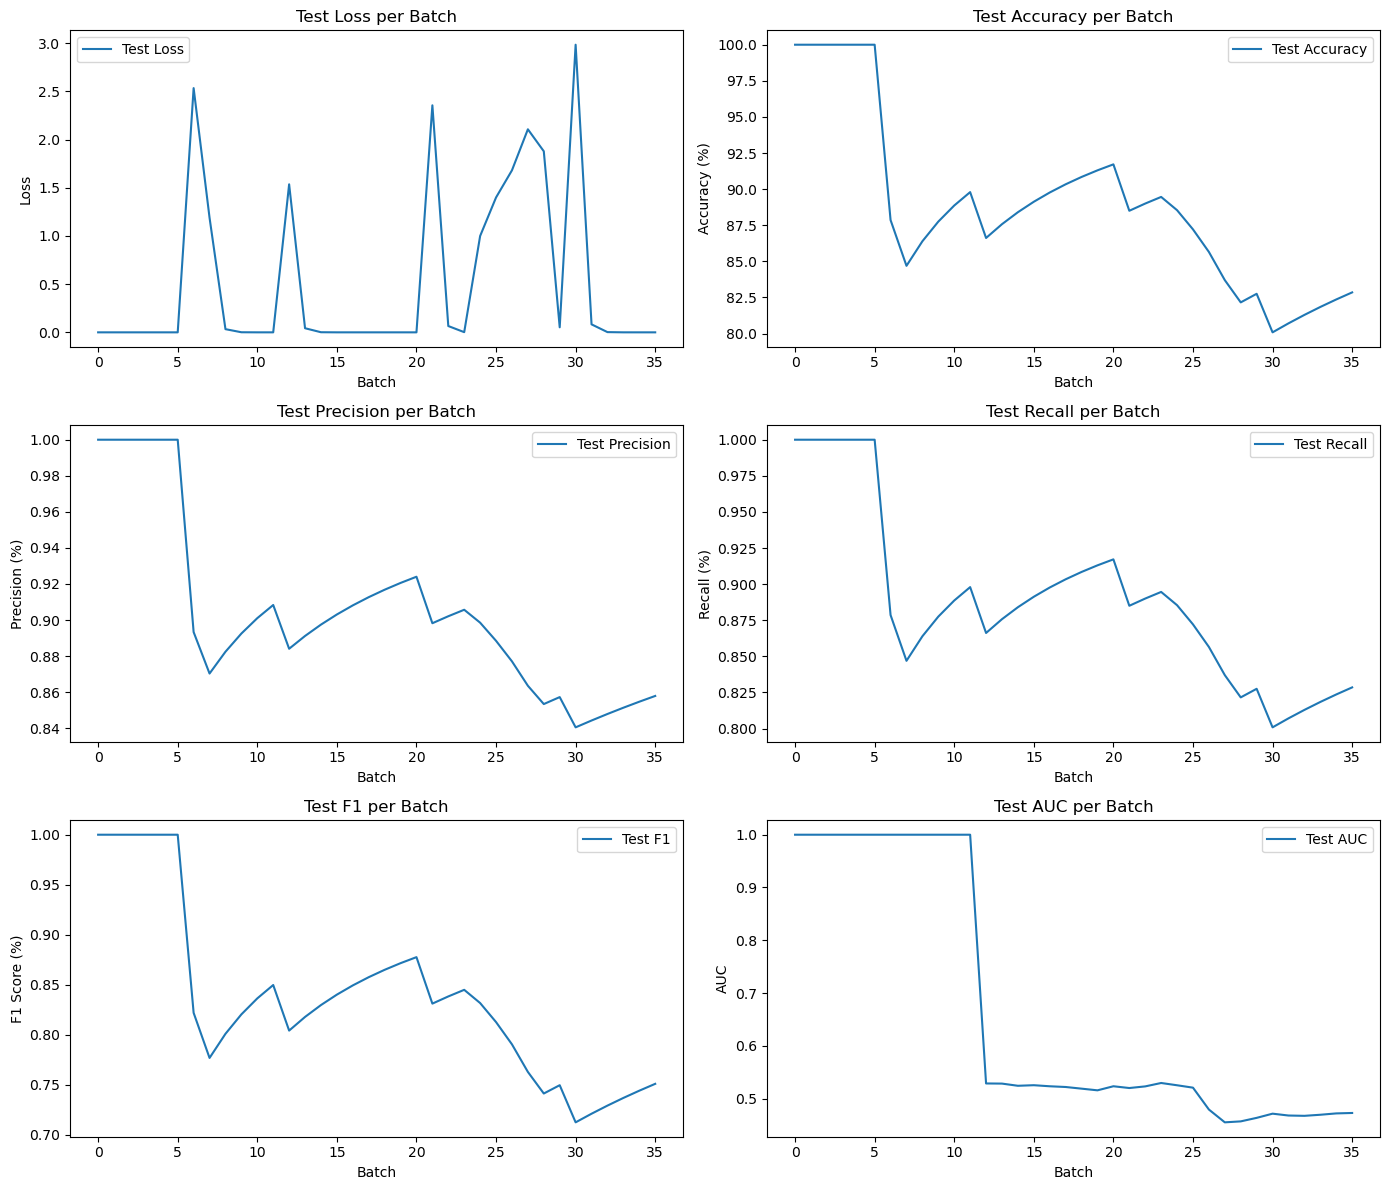

In [19]:
def test(model, test_loader, criterion, optimizer, scheduler, device):
    model.eval()
    test_losses = []
    test_accuracies = []
    test_precisions = []
    test_recalls = []
    test_f1s = []
    test_aucs = []
    all_test_labels = []
    all_test_preds = []
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    pos_weight = torch.tensor([10.0]).to(device)
    criterion_with_pos_weight = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    with torch.no_grad():
        for frames, labels in test_loader:            
            frames, labels = frames.to(device), labels.to(device)
            frames, labels = frames.float(), labels.float()
            frames = frames.view(-1, frames.shape[2], frames.shape[3], frames.shape[4], frames.shape[5])
            frames = frames.permute(0, 4, 1, 2, 3)    
            labels = labels.view(-1)         
           
            outputs = model(frames)
            
            loss = criterion_with_pos_weight(outputs.view(-1), labels)
            test_loss += loss.item()
            
            # Calculate accuracy
            predicted_test = torch.sigmoid(outputs.view(-1)) > 0.5
            total_test += labels.size(0)
            correct_test += (predicted_test == labels).sum().item()
                        
            # Collect labels and predictions for AUC and other metrics
            all_test_labels.append(labels.cpu().numpy())
            all_test_preds.append(outputs.view(-1).cpu().detach().numpy())
            
            # Compute metrics
            test_loss /= len(test_loader)
            test_losses.append(test_loss)
            test_accuracy = 100 * correct_test / total_test
            test_accuracies.append(test_accuracy)
            
            # Precision, Recall, F1 Score
            flat_labels = np.concatenate(all_test_labels)
            flat_preds = np.concatenate(all_test_preds) > 0.5
            
            test_precision = precision_score(flat_labels, flat_preds, average='weighted', zero_division=1)
            test_recall = recall_score(flat_labels, flat_preds, average='weighted', zero_division=1)
            test_f1 = f1_score(flat_labels, flat_preds, average='weighted', zero_division=1)
            
            # AUC score
            try:
                test_auc = roc_auc_score(flat_labels, np.concatenate(all_test_preds))
            except ValueError:
                test_auc = 1.0
            
            test_precisions.append(test_precision)
            test_recalls.append(test_recall)
            test_f1s.append(test_f1)
            test_aucs.append(test_auc)
            
            # Print scores per batch
            print(f'Batch Loss: {test_loss:.4f}, Batch Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}')
    
    
    test_avg_loss = np.mean(test_losses)
    test_avg_accuracy = np.mean(test_accuracies)
    test_avg_precision = np.mean(test_precisions)
    test_avg_recall = np.mean(test_recalls)
    test_avg_f1 = np.mean(test_f1s)
    test_avg_auc = np.mean(test_aucs)  
    
    # Update scheduler based on average test loss
    scheduler.step(test_avg_loss)

    return test_avg_loss, test_avg_accuracy, test_avg_precision, test_avg_recall, test_avg_f1, test_avg_auc, test_losses, test_accuracies, test_precisions, test_recalls, test_f1s, test_aucs

# Timing training / validation
test_start_time = time.time()
test_avg_loss, test_avg_accuracy, test_avg_precision, test_avg_recall, test_avg_f1, test_avg_auc, test_losses, test_accuracies, test_precisions, test_recalls, test_f1s, test_aucs = test(model, test_loader, criterion, optimizer, scheduler, device)
test_end_time = time.time()
test_duration = (test_end_time - test_start_time) / 60
print(f"Testing Duration: {test_duration:.2f} minutes")
print(f"Average Loss: {test_avg_loss:.4f}, Average Accuracy: {test_avg_accuracy:.4f}")
print(f'Average Precision: {test_avg_precision:.4f}, Average Recall: {test_avg_recall:.4f}, Average F1: {test_avg_f1:.4f}, Average AUC: {test_avg_auc:.4f}')

# Plot loss, accuracy, precision, recall, f1, and AUC
plt.figure(figsize=(14, 12))

plt.subplot(3, 2, 1)  # 3 rows, 2 columns, plot 1
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Test Loss per Batch')
plt.legend()

plt.subplot(3, 2, 2)  # 3 rows, 2 columns, plot 2
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per Batch')
plt.legend()

plt.subplot(3, 2, 3)  # 3 rows, 2 columns, plot 3
plt.plot(test_precisions, label='Test Precision')
plt.xlabel('Batch')
plt.ylabel('Precision (%)')
plt.title('Test Precision per Batch')
plt.legend()

plt.subplot(3, 2, 4)  # 3 rows, 2 columns, plot 4
plt.plot(test_recalls, label='Test Recall')
plt.xlabel('Batch')
plt.ylabel('Recall (%)')
plt.title('Test Recall per Batch')
plt.legend()

plt.subplot(3, 2, 5)  # 3 rows, 2 columns, plot 5
plt.plot(test_f1s, label='Test F1')
plt.xlabel('Batch')
plt.ylabel('F1 Score (%)')
plt.title('Test F1 per Batch')
plt.legend()

# Subplot 6: Test AUC
plt.subplot(3, 2, 6)  # 3 rows, 2 columns, plot 6
plt.plot(test_aucs, label='Test AUC')
plt.xlabel('Batch')
plt.ylabel('AUC')
plt.title('Test AUC per Batch')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [11]:
torch.save(model.state_dict(), 'best_model_res34_early.pth')